In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import flappy_bird_gymnasium
import gymnasium as gym
env = gym.make("CliffWalking-v0", render_mode="human")

obs, _ = env.reset()
for i in range(50):
    # Next action:
    # (feed the observation to your agent here)
    action = env.action_space.sample()

    # Processing:
    obs, reward, terminated, _, info = env.step(action)
    
    # Checking if the player is still alive
    if terminated:
        break

env.close()

In [10]:
LEARNING_RATE = 0.0007
EPISODES = 500
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
BATCH_SIZE = 64
MEMORY_SIZE = 10000
TARGET_UPDATE = 10
epsilon = EPSILON_START

# Neural Network for Q-Learning
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward','done'))

#the replayMemory Class
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
def select_action(policy_net,state):
    if random.random()<epsilon:
         action = env.action_space.sample()
         return action
    else:
        
        state = torch.tensor(state,dtype=torch.float32).unsqueeze(0)
        return policy_net(state).argmax(dim=1).item()

def train_dqn(policy_net,target_net,memory,optimizer):
    if memory.__len__()<BATCH_SIZE:
        return 0
    sample = memory.sample(BATCH_SIZE)


    batch = Transition(*zip(*sample))
    
    
    states = torch.tensor(batch.state,dtype=torch.float32)
    actions = torch.tensor(batch.action,dtype=torch.int64).unsqueeze(1)
    next_states = torch.tensor(batch.next_state,dtype=torch.float32)
    rewards = torch.tensor(batch.reward,dtype=torch.float32)
    dones = torch.tensor(batch.done,dtype=torch.float32)
    


    current_q_values = policy_net(states).gather(1,actions)
    
    next_q_values =  target_net(next_states).max(1)[0].detach()
    target_q_values = rewards +(GAMMA * next_q_values * (1 - dones))

    loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
    
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

# this function used to encode state into vectors like array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
def one_hot_encode(state, num_states):
    one_hot = np.zeros(num_states)
    one_hot[state] = 1
    return one_hot

Episode 0, Reward: -1141.4999999999989, Epsilon: 0.99 , Loss: 546.340576171875
Episode 1, Reward: -1339.4999999999989, Epsilon: 0.99 , Loss: 252.10325622558594
Episode 2, Reward: -1141.4999999999989, Epsilon: 0.99 , Loss: 144.26028442382812
Episode 3, Reward: -1537.499999999999, Epsilon: 0.98 , Loss: 2.009955406188965
Episode 4, Reward: -1438.4999999999989, Epsilon: 0.98 , Loss: 11.268827438354492
Episode 5, Reward: -1042.4999999999989, Epsilon: 0.97 , Loss: 0.21010559797286987
Episode 6, Reward: -1339.4999999999989, Epsilon: 0.97 , Loss: 9.920485496520996
Episode 7, Reward: -1933.4999999999989, Epsilon: 0.96 , Loss: 0.025741348043084145
Episode 8, Reward: -1735.4999999999989, Epsilon: 0.96 , Loss: 0.011996816843748093
Episode 9, Reward: -2131.500000000002, Epsilon: 0.95 , Loss: 2.3442676067352295
Episode 10, Reward: -646.4999999999991, Epsilon: 0.95 , Loss: 0.1108652651309967
Episode 11, Reward: -1141.4999999999989, Epsilon: 0.94 , Loss: 1.175567626953125
Episode 12, Reward: -1438.499

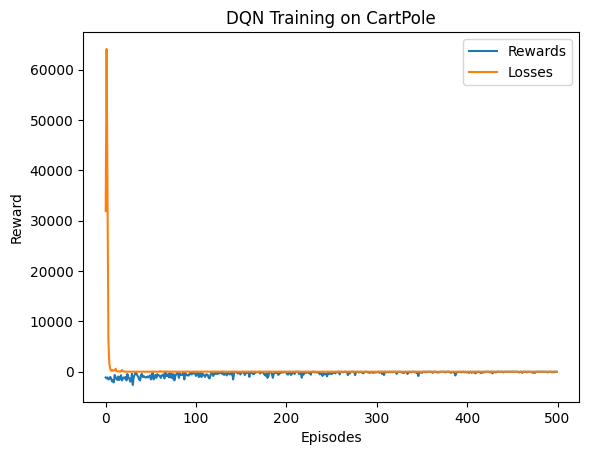

In [11]:
# LEARNING_RATE = 0.0001
# EPISODES = 1000
env = gym.make("CliffWalking-v0")
state_dim = env.observation_space.n
action_dim = env.action_space.n

# trained_model = DQN(state_dim, action_dim)
# trained_model.load_state_dict(torch.load("dqn_flappy_bird.pth"))  

policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)

target_net.load_state_dict(policy_net.state_dict())
# policy_net.load_state_dict(trained_model.state_dict())

policy_net.train()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(MEMORY_SIZE)


rewards = []
losses=[]


for episode in range(EPISODES):
    state = env.reset()[0]
    episode_reward = 0
    episode_loss=0

    for t in range(150):
        state = one_hot_encode(state, state_dim)
        action = select_action( policy_net,state)
        next_state, reward, done, truncated, __= env.step(action)
        reward = reward - 0.01
        
        
        memory.push(state, action, one_hot_encode(next_state, state_dim), reward, done)

        loss = train_dqn(policy_net, target_net, memory, optimizer)

        state = next_state
        episode_reward += reward
        
        episode_loss+=loss

        if done or truncated:
            break

    # Decay epsilon
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    rewards.append(episode_reward)
    losses.append(episode_loss)
    print(f"Episode {episode}, Reward: {episode_reward}, Epsilon: {epsilon:.2f} , Loss: {loss}")

# Save the trained model
torch.save(policy_net.state_dict(), "CliffWalking.pth")


plt.figure(figsize=(12, 6))

# Plot rewards
plt.subplot(1, 2, 1)
plt.plot(rewards, label='Rewards', color='blue')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Rewards Over Episodes')
plt.legend()

# Plot losses
plt.subplot(1, 2, 2)
plt.plot(losses, label='Losses', color='red')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Losses Over Episodes')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
env = gym.make("CliffWalking-v0",render_mode="human")
state_dim = env.observation_space.n
action_dim = env.action_space.n

# Load the trained DQN model
policy_net = DQN(state_dim, action_dim)
policy_net.load_state_dict(torch.load("CliffWalking.pth"))  # Replace with your saved model path
policy_net.eval()  # Set the model to evaluation mode

def play_cartpole(env, policy_net, episodes=5, render=True):
    total_rewards = 0

    for episode in range(episodes):
        state = env.reset()[0]
        # state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        episode_reward = 0
        done = False
        truncated = False
        while not done and not truncated:
            if render:
                env.render()

            # Use the model to select the best action
            with torch.no_grad():
                state = one_hot_encode(state, state_dim)
                state = torch.tensor(state,dtype = torch.float)
                q_values = policy_net(state)
                action = torch.argmax(q_values).item()

            # Perform the selected action
            next_state, reward, done, truncated,__= env.step(action)
            episode_reward += reward

            # Update state
            state = next_state

        total_rewards+=episode_reward
        print(f"Episode {episode + 1}: Reward = {episode_reward}")

    env.close()
    print(f"episodes: {episodes} total rewards: {(total_rewards)}")

# Test the trained model
play_cartpole(env, policy_net, episodes=5, render=True)

Episode 1: Reward = -13
Episode 2: Reward = -13
Episode 3: Reward = -13
Episode 4: Reward = -13
Episode 5: Reward = -13
episodes: 5 total rewards: -65
